In [89]:
%pylab inline
import numpy as np
import torch
import os
import time
import pandas as pd
import nibabel as nib

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader

from sklearn.preprocessing import StandardScaler
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *
from Model_alphaWGAN import *
import pytorch_ssim
import matplotlib.pyplot as plt
from ipdb import set_trace
from utils import *

Populating the interactive namespace from numpy and matplotlib


/usr/local/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time', 'resize', 'plotting', 'Generator']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Configuration

In [90]:
# used to store the MMD ans MS-SSIM
try:
    os.mkdir('./test_data')
except FileExistsError:
    pass
workers = 4
BATCH_SIZE = 8
latent_dim = 1000

Use_BRATS = False
Use_ATLAS = False
gpu = 0

In [91]:
trainset = ADNIdataset(augmentation=True)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
#'flair' or 't2' or 't1ce'
# trainset = BRATSdataset(imgtype='flair')
# train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
#                                                num_workers=workers)

# trainset = ATLASdataset(augmentation=True)
# train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

gen_load = inf_train_gen(train_loader)

## Pre-trained Generator Load

In [92]:
#-------------------------------------------
#Choose the Model you want!
# from Model_alphaWGAN import *
from Model_alphaWGAN import Discriminator
from Model_alphaGAN import Generator
# from Model_VAEGAN import Generator
# from Model_VAEGAN import Encoder
# from Model_WGAN import Generator
#-------------------------------------------

G = Generator(noise=latent_dim).cuda(gpu)
# E = Encoder(out_class = latent_dim).cuda(gpu)
E = Discriminator(out_class = latent_dim, is_dis=False).cuda(gpu)
#-----------------------
#Load Pre-trained model
#-----------------------

#------------Trained Model of ADNI dataset---------------------
# G.load_state_dict(torch.load('./vae_checkpoint_gp/G_iter.pth')) 
# G.load_state_dict(torch.load('./alpha_checkpoint_2/G_iter100000.pth')) 
# E.load_state_dict(torch.load('./alpha_checkpoint_2/E_iter100000.pth')) 

#------------Trained Model of ATLAS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_at_G.pth'))

#------------Trained Models of BRATS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_fl_G.pth'))
# G.load_state_dict(torch.load('./checkpoint/Ours_t2_G.pth'))

Fake Image - slice series visualization

You can change the axis (x , y , z ) by changing  display_mode = 'x' / 'y' / 'z'

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


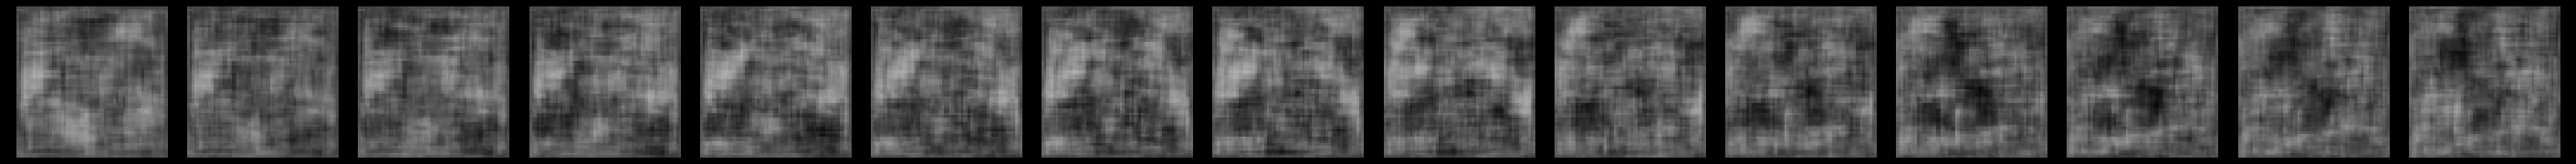

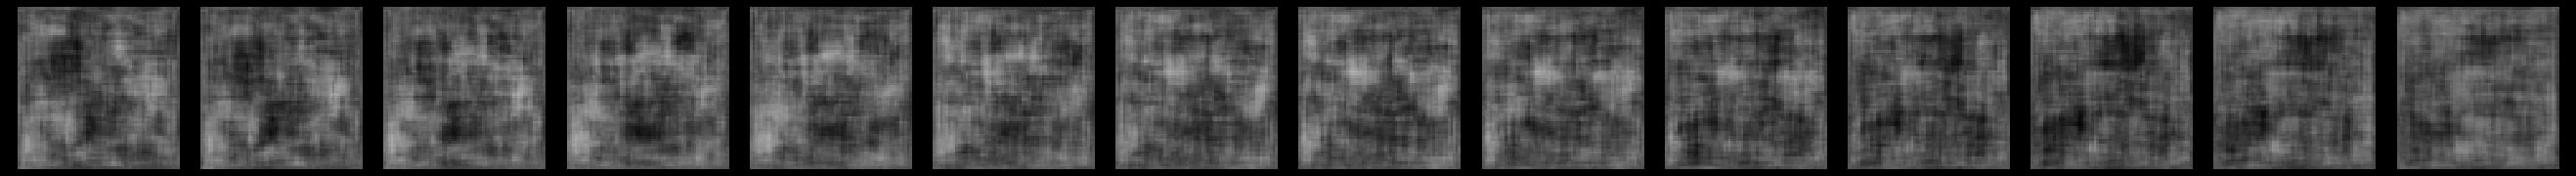

In [77]:
Show_color = False

noise = torch.randn(1, latent_dim).cuda(gpu)
fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))

arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]
if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

Fake Image - Center cut slices Visualization

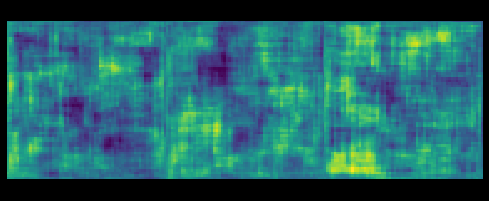

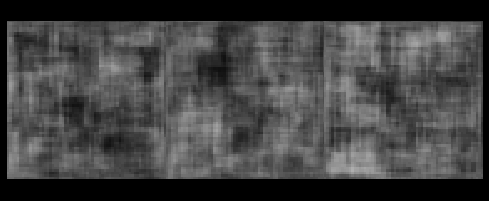

In [78]:
noise = Variable(torch.randn((1, 1000)).cuda(gpu))
# fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
plotting.plot_img(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.plot_anat(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.show()

Real Image - Slice series visualization

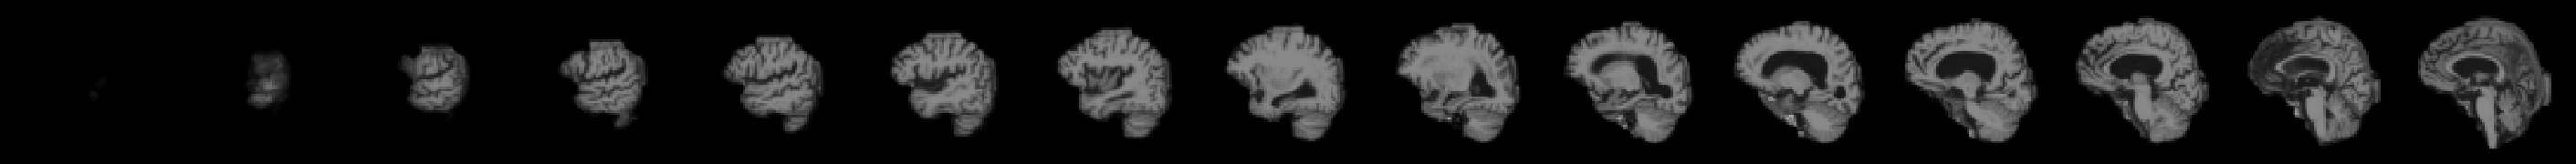

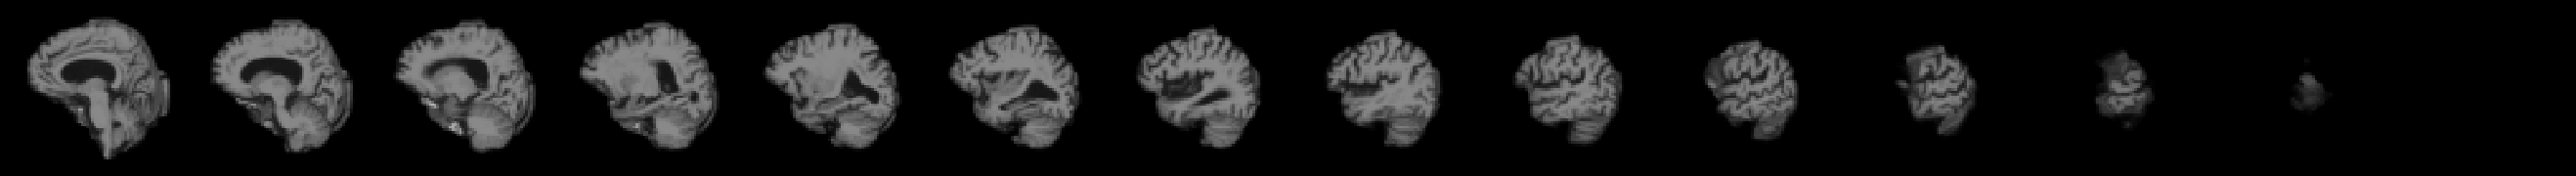

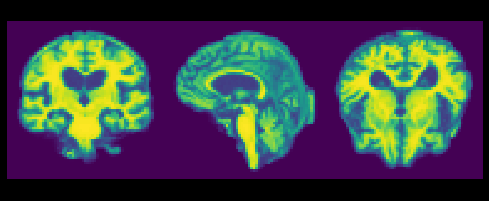

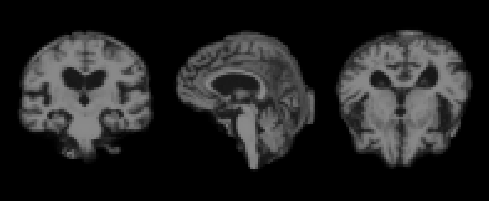

In [79]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)

Show_color = False

image = gen_load.__next__()
featmask = np.squeeze(image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]

if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

plotting.plot_img(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.plot_anat(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.show()

# MS-SSIM Calculation

In [15]:
G.load_state_dict(torch.load('./mmd_checkpoint/G_iter42000.pth'))
sum_ssim = 0
for i in range(1000):
    noise = Variable(torch.randn((2, 1000)).cuda(gpu))
    images = gen_load.__next__().cuda(gpu)
#   images = G(noise)
    img1 = images[0]
    img2 = images[1]

    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    if i % 100 == 0:
        print(sum_ssim/1000)
print(f'final ssim: {sum_ssim/1000}')

FileNotFoundError: [Errno 2] No such file or directory: './mmd_checkpoint/G_iter42000.pth'

# MS-SSIM Curve

In [ ]:
ssim_pth = 'alpha_checkpoint_2'
last_ind = read_ssim(path=ssim_pth)
last_ind = 1000 if not last_ind else last_ind
inds = [1000] + list(range(5000, 200001, 5000))
for i in inds[inds.index(last_ind):]:
#     G.load_state_dict(torch.load(f'./{ssim_pth}/G_VG_ep_{i}.pth'))
    G.load_state_dict(torch.load(f'./{ssim_pth}/G_iter{i}.pth'))
    calc_ssim(G, i, ssim_pth, no_write=False, gpu=gpu)

In [ ]:
%debug

# MS-SSIM for real images

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)

i = 0
sum_ssim = 0
while i < 494:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
        
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)
while i < 494 * 2:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
print(sum_ssim/(494 * 2))

# Maximum-Mean Discrepancy Score

### calculate averaged mmd score

In [93]:
mode = 'linear'
mmd_pth = 'adni_cce_checkpoint_3'
i = 
G.load_state_dict(torch.load(f'./{mmd_pth}/G_iter60000.pth')) 
calc_mmd(train_loader, G, 40000, count=10, gpu_ind=gpu, mode=mode, path=mmd_pth, no_write=True)

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


KeyboardInterrupt: 

### create mmd cruve

In [ ]:
mode ='rbf'
mmd_pth = 'wl_checkpoint_mse_3_'
for i in range(2000, 100000, 1000):
    i = int(i / 1000) if 'vae' in mmd_pth else i
    G.load_state_dict(torch.load(f'./{mmd_pth}/G_iter{i}.pth'))
#     G.load_state_dict(torch.load(f'./{mmd_pth}/G_VG_ep_{i}.pth'))
    calc_mmd(train_loader, G, i, count=1, gpu_ind=gpu, mode=mode, path=mmd_pth, no_write=False)

In [ ]:
mode ='rbf'
mmd_pth = 'wl_checkpoint_mse_3'
last_ind = int(read_mmd(mmd_pth, name=f'{mode}_mmd.csv'))
end = 101000
last_ind = last_ind * 1000 if 'vae' in mmd_pth else last_ind
if not last_ind:
    inds = [1000] + list(range(5000, end, 5000))
elif last_ind == 1000:
    inds = range(5000, end, 5000)
else: 
    inds = range(last_ind + 5000, end, 5000)
for i in inds:
    i = int(i / 1000) if 'vae' in mmd_pth else i
    G.load_state_dict(torch.load(f'./{mmd_pth}/G_iter{i}.pth'))
#     G.load_state_dict(torch.load(f'./{mmd_pth}/G_VG_ep_{i}.pth'))
    calc_mmd(train_loader, G, i, count=10, gpu_ind=gpu, mode=mode, path=mmd_pth, no_write=False)

In [ ]:
%debug

### visualize mmd curve

In [ ]:
df = load_csv('./trained/wl_gan_mmd.csv')
plt.figure()
df['mmd_score'].plot()

### T-SNE Visualization

### T-SNE / PCA


is_tsne: False, is_pca: True


/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 15000, sample_mean (blue): -0.8796917200088501 sample_var:        0.042499057948589325, real_mean (yellow): -0.8608890771865845 real_var: 0.05474768951535225


<Figure size 432x288 with 0 Axes>

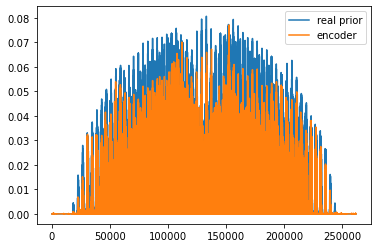

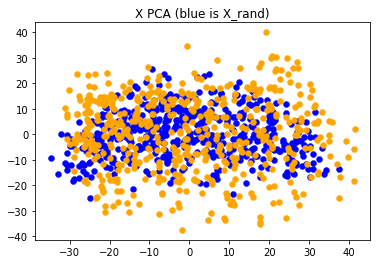

FileNotFoundError: [Errno 2] No such file or directory: './adni_cce_checkpoint_2/G_iter20000.pth'

In [82]:
pth = 'adni_cce_checkpoint_2'
G = Generator(noise=latent_dim).cuda(gpu)
for i in range(35000, 200001, 5000):
    G.load_state_dict(torch.load(f'./{pth}/G_iter{i}.pth'))
    viz_pca_tsne([G], trainset, index=i, is_cd=False, is_pca=True, is_tsne=False, latent_size=latent_dim, gpu_ind=gpu, batch_size=1)  
    

In [ ]:
### colors=['blue', 'red', 'pink', 'green', 'orange']
names = ['vae4', 'alpha2', 'wl7', 'wl19', 'real']
for n in [0, 1, 2, 3, 4]:
    df = pd.read_csv(f'./{names[n]}_G_PCA.csv')
    plt.scatter(df.values[:, 0], df.values[:, 1], color=colors[n], alpha=0.5, linewidths=1e-7)

In [ ]:
%debug

> <ipython-input-2-a76f4c8be5c9>(4)<module>()
      1 colors=['blue', 'red', 'pink', 'green', 'orange']
      2 names = ['vae4', 'alpha2', 'wl7', 'wl19', 'real']
      3 for n in [0, 1, 2, 3, 4]:
----> 4     df = pd.read_csv(f'./{names[n]}_G_PCA.csv')
      5     plt.scatter(df.values[:, 0], df.values[:, 1], color=colors[n], alpha=0.5, linewidths=1e-7)

--KeyboardInterrupt--
--KeyboardInterrupt--
ipdb> exit


### X PCA Visualization

In [ ]:
pca_pth = 'wl_checkpoint'
for i in range(100000, 0, -5000):
# for i in range(122, -1, -10):
    G.load_state_dict(torch.load(f'./{pca_pth}/G_iter{i}.pth'))
    viz_pca_tsne(G, trainset, latent_size=latent_dim, gpu_ind=gpu)

In [ ]:
def show_pca_cluster(x, PC_list, interval=3):
    for i in range(x, x+interval):
        sample_ind = PC_list[i][2]
        feat = sample_df.iloc[int(sample_ind)].to_numpy().reshape((64, 64, 64))
        featmask = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(featmask, title=f'x_val: {round(PC_list[i][0], 2)} y_val: {round(PC_list[i][1], 2)} sample_index: {int(sample_ind)}')
        plotting.show()

# concatenate the sample index 
PC_list = list(np.concatenate((PCs, np.array([i for i in range(512)]).reshape(512, 1)), 1ghgng
# sort by x or y of PCAs
PC_list.sort(key=lambda x: x[1])

# for i in range(0, 512, 60):
#     show_pca_cluster(i, PC_list, 1)

show_pca_cluster(0, PC_list, 10)



### visualize all training images

In [ ]:
viz_all_imgs('../../ADNI', [0])

### loss check

<AxesSubplot:>

<Figure size 28800x28800 with 0 Axes>

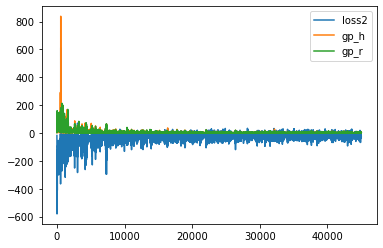

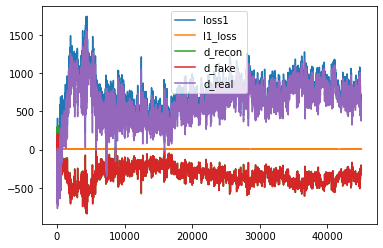

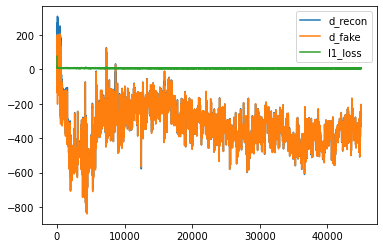

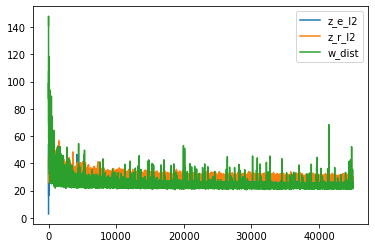

In [64]:
loss_df = load_loss(path='./adni_cce_checkpoint_3/')
# print(loss_df)
# alpha_wgan
plt.figure(figsize=(400, 400))
loss_df[['loss2','gp_h','gp_r',]].plot() 
loss_df[['loss1','l1_loss','d_recon','d_fake','d_real']].plot()
loss_df[['d_recon','d_fake','l1_loss']].plot()
loss_df[['z_e_l2', 'z_r_l2', 'w_dist']].plot()
# vae_gan
# loss_df[['d_real_loss', 'd_fake', 'd_recon', 'err_enc']].plot() 

# plt.figure()
# # loss_df[['loss1', 'mmd_loss']].plot()
# plt.figure()
# loss_df[['gp_r', 'gp_h', 'l1_loss']].plot()

In [ ]:
%debug

### Z space pca

In [ ]:
E.load_state_dict(torch.load(f'./wl_checkpoint_mse/E_iter100000.pth'))
for i in [1, 10, 100, 1000]:
    viz_pca(E, trainset, latent_size=latent_dim, index=100000, is_cd=True, gpu_ind=gpu)

In [ ]:
%debug

In [ ]:
# for VAEGAN
for i in range(100, -1, -10):
    E.load_state_dict(torch.load(f'./vae_checkpoint_1/E_VG_ep_{i}.pth'))
    viz_pca(E, trainset, latent_size=latent_dim, index=i, is_cd=True, gpu_ind=gpu, batch_size=1)

In [ ]:
# for AlphaWGAN
for i in range(42000, 0, -2000):
    E.load_state_dict(torch.load(f'./wl_checkpoint/E_iter{i}.pth'))
    viz_pca(E, trainset, latent_size=latent_dim, index=i, is_cd=True, gpu_ind=gpu)

### delete CD and D

# Calculate the paddings of fake images

In [ ]:
G = Generator(noise=1000).cuda(gpu)
G.load_state_dict(torch.load('./trained/G_iter12500.pth'))

def get_padding(feat, axis=0):
    feat = np.swapaxes(feat, 0, axis)
    output = [0, 0]
    for i in range(feat.shape[0]):
#         print(feat[i].sum())
        if feat[i].sum() > -4000:
            output[0] = i
            break
    for i in range(feat.shape[0] - 1, -1, -1):
        if feat[i].sum() > -4000:
            output[1] = feat.shape[0] - i - 1
            break
    return output
    
for i in range(512):
    noise = torch.rand((1, 1000)).cuda(gpu)
    img = G(noise)
    featmask = np.squeeze((0.5*img+0.5).detach().cpu().numpy())
    print(f'ind: {i} padding 0-axis: {get_padding(featmask, 0)}', end=' ')
    print(f'ind: {i} padding 1-axis: {get_padding(featmask, 1)}', end=' ')
    print(f'ind: {i} padding 2-axis: {get_padding(featmask, 2)}')
#     featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
#     plotting.plot_img(featmask, title=f'ind: {i}')
#     plotting.show()

### intensity range check

In [ ]:
trainset = ADNIdataset(augmentation=True, img_size=64, normalization=False)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
for featmask in inf_train_gen(train_loader):
#     noise = torch.rand((1, 1000)).cuda()
#     featmask= G(noise)
#     featmask = np.squeeze((0.5*featmask+0.5).detach().cpu().numpy())
    lo, hi = featmask.min(), featmask.max()
    print(f'lo: {lo} hi: {hi}')
#     featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
#     plotting.plot_img(featmask, title=f'ind: {i}')
#     plotting.show()
    

In [ ]:
%debug

In [ ]:
from utils import sinkhorn_pointcloud as sp
import numpy as np
import torch
from ipdb import set_trace
from torch import optim
from torch.autograd import Variable

gpu=1
a = Variable(torch.randn((1000, 4)).cuda(gpu), requires_grad=True)
b = Variable(torch.randn((1000, 4)).cuda(gpu) * 0.01, requires_grad=True) 
g_optimizer = optim.Adam([a, b], lr=0.0002)
print(a.shape, b.shape)
for i in range(1000):
    g_optimizer.zero_grad()
    w_dist = sp.sinkhorn_loss(a, b, 0.1, 1000, 100, gpu=gpu)
    w_dist.backward()
    g_optimizer.step()
    
    if i % 100 == 0:
        print(w_dist)

In [ ]:
a = torch.randn((1, 5), requires_grad=True)
c = a * 2
c.requires_grad = True;
b = c.sum()
b.backward()
print(a.grad)
print(c.grad)
print(b.grad)
